In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dyflownet as dfn

In [2]:
def generate_boundary_combos(*arrays):
    array_list = [np.asarray(a) for a in arrays]
    N = len(array_list)

    endpoint = [[array[0], array[-1]] for array in array_list]
    
    grid = np.meshgrid(*arrays, indexing="ij")
    unravel = np.array([k.ravel() for k in grid])
    
    is_endpoint = []
    for i in range(N):
        is_endpoint.append((unravel[i, :] == endpoint[i][0]) | (unravel[i, :] == endpoint[i][1]))
        
    return unravel[:, np.any(is_endpoint, axis=0)]

## Freeway-Ramp Junction

In [3]:
num_x_grid, num_y_grid = 26, 26

initial_condition = generate_boundary_combos(np.linspace(0, 5, num_x_grid), np.linspace(0, 5, num_y_grid))

state_len = len(initial_condition[0, :])

source_0 = dfn.cell.Source(ID = 'source_0', state_len = state_len,
                           initial_condition = {'density': [0]*state_len}, 
                           boundary_inflow = dfn.flow.BoundaryInflow(boundary_inflow=0.8),
                           sending = dfn.flow.BufferSendingFlow(demand=0.8, capacity=1, ignore_queue=True))


source_1 = dfn.cell.Source(ID = 'source_1', state_len = state_len,
                           initial_condition = {'density': [0]*state_len}, 
                           boundary_inflow = dfn.flow.BoundaryInflow(boundary_inflow=0.2),
                           sending = dfn.flow.BufferSendingFlow(demand=0.2, capacity=1, ignore_queue=True))


link_0 = dfn.cell.Link(ID = 'link_0', state_len = state_len,
                       initial_condition = {'density': initial_condition[0, :]}, 
                       receiving = dfn.flow.PiecewiseLinearReceivingFlow(congestion_wave_speed=0.25, max_density=5, capacity=1),
                       sending = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=1, capacity=1))

sink_0 = dfn.cell.Sink(ID = 'sink_0', state_len = state_len,
                       initial_condition = {'density': initial_condition[1, :]}, 
                       receiving = dfn.flow.PiecewiseLinearReceivingFlow(congestion_wave_speed=0.25, max_density=5, capacity=1),
                       boundary_outflow = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=1, capacity=1))


sink_1 = dfn.cell.Sink(ID = 'sink_1', state_len = state_len,
                       initial_condition = {'density': [0]*state_len}, 
                       receiving = dfn.flow.UnboundedReceivingFlow(),
                       boundary_outflow = dfn.flow.PiecewiseLinearSendingFlow(free_flow_speed=1, capacity=1))


junction_0 = dfn.node.BasicJunction(ID = 'node_0', incoming_cell_list = [source_0], outgoing_cell_list = [link_0])

junction_1 = dfn.node.FreewayRampJunction(ID = 'node_1', incoming_cell_list = [link_0, source_1], outgoing_cell_list = [sink_0, sink_1],
                                          split_ratio = [0.9, 0.1], merging_priority = [0, 1])



num_step = 5000

net_0 = dfn.net.Network(ID='net_0', num_step=num_step, time_step_size=0.01)

net_0.add_component('source', source_0)
net_0.add_component('source', source_1)
net_0.add_component('link', link_0)
net_0.add_component('sink', sink_0)
net_0.add_component('sink', sink_1)

net_0.add_component('node', junction_0)
net_0.add_component('node', junction_1)

net_0.run()

time cost: 1.9 seconds.


In [4]:
X, Y = np.meshgrid(np.linspace(0, 5, num_x_grid), np.linspace(0, 5, num_y_grid), indexing='ij')

sending_source_0 = source_0.flow_dict['sending'].calculate_flow() * np.ones([num_x_grid, num_y_grid])

sending_source_1 = source_1.flow_dict['sending'].calculate_flow() * np.ones([num_x_grid, num_y_grid])

receiving_link_0 = link_0.flow_dict['receiving'].calculate_flow(X)
sending_link_0 = link_0.flow_dict['sending'].calculate_flow(X)

receiving_sink_0 = sink_0.flow_dict['receiving'].calculate_flow(Y)
outflow_sink_0 = sink_0.flow_dict['boundary_outflow'].calculate_flow(Y)

receiving_sink_1 = sink_1.flow_dict['receiving'].calculate_flow() * np.ones([num_x_grid, num_y_grid])

inflow_link_0 = junction_0.assign_inter_cell_flow([sending_source_0], [receiving_link_0])[1][0]
outflow_link_0 = junction_1.assign_inter_cell_flow([sending_link_0, sending_source_1], [receiving_sink_0, receiving_sink_1])[0][0]

inflow_sink_0 = junction_1.assign_inter_cell_flow([sending_link_0, sending_source_1], [receiving_sink_0, receiving_sink_1])[1][0]

U = inflow_link_0 - outflow_link_0
V = inflow_sink_0 - outflow_sink_0

norm = np.sqrt(U**2+V**2)

U_normed = np.divide(U, norm, out=np.zeros_like(U), where=norm!=0)
V_normed = np.divide(V, norm, out=np.zeros_like(V), where=norm!=0)

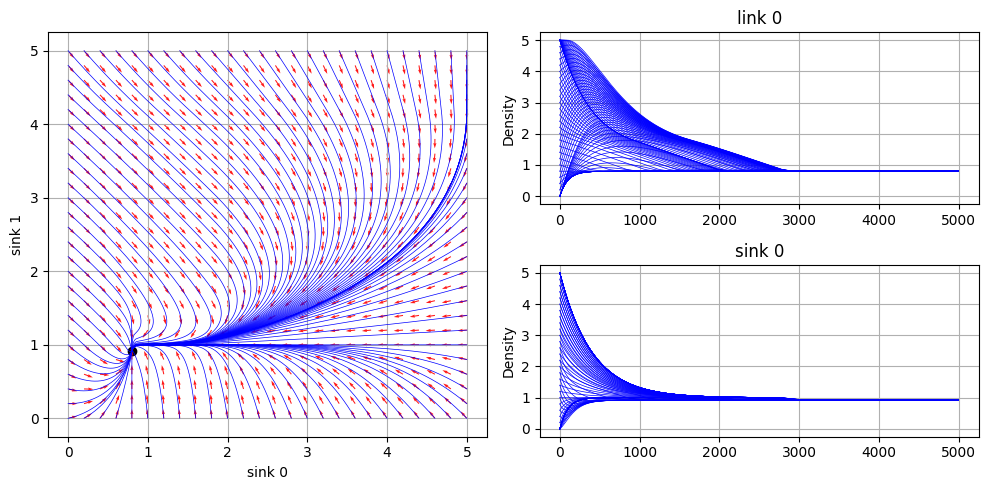

In [5]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.scatter([0.8], [0.92], color='k')
plt.plot(link_0.state_output['density'], sink_0.state_output['density'],  'b', linewidth=0.5)
plt.quiver(X, Y, U_normed, V_normed, color='red', alpha=0.9)
plt.xlabel('sink 0')
plt.ylabel('sink 1')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(link_0.state_output['density'], 'b', linewidth=0.5)
plt.title('link 0')
plt.ylabel('Density')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(sink_0.state_output['density'], 'b', linewidth=0.5)
plt.title('sink 0')
plt.ylabel('Density')
plt.grid()

plt.tight_layout()

plt.show()